# Hazard class

A Hazard contains the following information:

- tag (TagHazard): information about the source
- units (str): units of the intensity
- centroids (Centroids): centroids of the events
- event_id (np.array): id (>0) of each event
- event_name (list(str)): name of each event (default: event_id)
- date (np.array): integer date corresponding to the proleptic Gregorian ordinal, where January 1 of year 1 has ordinal 1 (ordinal format of datetime library)
- frequency (np.array): frequency of each event in seconds
- orig_event (np.array): flags indicating historical events (True) or probabilistic (False)
- intensity (sparse.csr_matrix): intensity of the events at centroids
- fraction (sparse.csr_matrix): fraction of affected exposures for each event at each centroid

Note that `intensity` and `fraction` are scipy.sparse matrices of size num_events x num_centroids. The `Centroids` class contains the geographical coordinates where the hazard is defined. A `Centroids` instance provides each coordinate with an id and can't contain two identical coordinates. 

## Read Hazards

Hazards can be read from Excel files following the template in `climada_python/data/system/hazard_template.xlsx` using the `read_excel()` method. Hazards generated with CLIMADA's MATLAB version (.mat format) can be read using `read_mat()`. Hazards generated with the CLIMADA in Python (.h5 format) can be read using `read_hdf5()`.

In [1]:
from climada.hazard import Hazard
from climada.util import HAZ_DEMO_H5 # CLIMADA's Python file
# Hazard needs to know the acronym of the hazard type to be constructed!!! Use 'NA' if not known.
haz_tc_fl = Hazard('TC')
haz_tc_fl.read_hdf5(HAZ_DEMO_H5)  # Historic and synthetic tropical cyclones in Florida from 1975 to 2011
haz_tc_fl.check() # Use always the check() method to see if the hazard has been loaded correctly

2019-03-04 09:45:05,303 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf


/Users/aznarsig/anaconda3/envs/climada_env_new/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2019-03-04 09:45:10,016 - climada.util.checker - DEBUG - Centroids.region_id not set. 


Other types of data can be ingested using Python libraries. Whilst every case might be different, in general raster data can be loaded using `gdal` library as follows:

Opening file /Users/aznarsig/Documents/Python/climada_python/data/demo/SC22000_VE__M1.grd.gz
2019-03-04 09:45:13,786 - climada.util.checker - DEBUG - Centroids.region_id not set. 


(<Figure size 648x936 with 2 Axes>,
 array([[<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x1a126304e0>]],
       dtype=object))

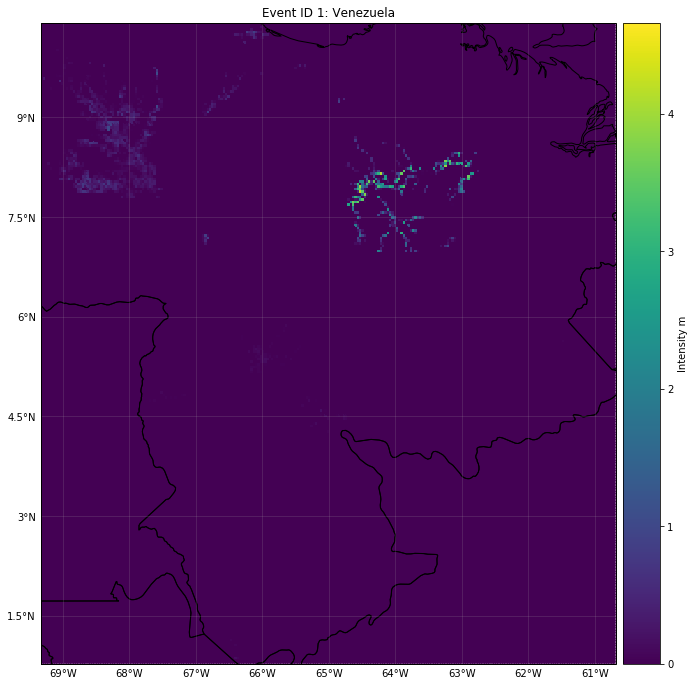

In [2]:
%matplotlib inline
import numpy as np
from scipy import sparse
import gdal

from climada.hazard import Hazard
from climada.util.constants import HAZ_DEMO_FL

# read raster data of flood in Venezuela
MODEL_NAN = -9999

print('Opening file', HAZ_DEMO_FL)
haz_file = gdal.Open('/vsigzip/' + HAZ_DEMO_FL)

haz_data = haz_file.ReadAsArray()
haz_data[haz_data == MODEL_NAN] = 0.
haz_data[np.isnan(haz_data)] = 0.

ulx, xres, xskew, uly, yskew, yres  = haz_file.GetGeoTransform()
lrx = ulx + (haz_file.RasterXSize * xres)
lry = uly + (haz_file.RasterYSize * yres)

x_points = np.arange(ulx+xres/2, lrx, xres)
y_points = np.arange(uly+yres/2, lry, yres)
grid_x, grid_y = np.meshgrid(x_points, y_points)

# fill hazard
haz = Hazard('FL')
haz.centroids.coord = np.zeros((grid_x.size, 2))
haz.centroids.coord[:, 0] = grid_y.flatten()
haz.centroids.coord[:, 1] = grid_x.flatten()
haz.centroids.id = np.arange(haz.centroids.coord.shape[0])
haz.intensity = sparse.csr_matrix(haz_data.flatten())
haz.units = 'm'
haz.event_id = np.ones(1, int)
haz.event_name.append('Venezuela')
haz.date = np.ones(1, int)
haz.orig = np.zeros(1, bool)
haz.frequency = np.ones(1)*0.01
haz.fraction = haz.intensity.copy()
haz.fraction.data.fill(1)
haz.check()

# plot hazard
haz.plot_intensity('Venezuela')

## Methods

The following methods can be used to analyse the data in `Hazard`:

- `calc_year_set()` method returns a dictionary with all the historical (not synthetic) event ids that happened at each year. 
- `get_event_date()` returns strings of dates in ISO format.
- To obtain the relation between event ids and event names, two methods can be used `get_event_name()` and `get_event_id()`. 

Other methods to handle one or several Hazards are:
- the property `size` returns the number of events contained.
- `append()` is used to expand the data with data from another `Hazard`.
- `select()` returns a new hazard with the selected region, date and/or synthetic or historical filter.
- `remove_duplicates()`: removes events with same name and date.
- `local_exceedance_inten()` returns a matrix with the exceedence frequency at every frequency and provided return periods. This is the one used in `plot_rp_intensity()`.

### EXERCISE:

Using the previous hazard `haz_tc_fl` answer these questions:
1. How many synthetic events are contained?
2. Generate an hazard with historical hurricanes ocurring between 1995 and 2001.
3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?

In [3]:
# Put your code here:





In [4]:
# SOLUTION:

# 1.How many synthetic events are contained?
print('Number of total events:', haz_tc_fl.size)
print('Number of synthetic events:', np.logical_not(haz_tc_fl.orig).astype(int).sum())

# 2. Generate an hazard with historical hurricanes ocurring between 1995 and 2001.
hist_tc = haz_tc_fl.select(date=('1995-01-01', '2001-12-31'), orig=True)
print('Number of historical events between 1995 and 2001:', hist_tc.size)

# 3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?
ev_per_year = hist_tc.calc_year_set() # events ids per year
print('Number of events in 1999:', ev_per_year[1999].size)
max_year = 1995
max_ev = ev_per_year[1995].size
for year, ev in ev_per_year.items():
    if ev.size > max_ev:
        max_year = year
print('Year with most hurricanes between 1995 and 2001:', max_year)

Number of total events: 2405
Number of synthetic events: 1924
Number of historical events between 1995 and 2001: 109
Number of events in 1999: 16
Year with most hurricanes between 1995 and 2001: 1995


## Visualize Hazards

There are three different plot functions: `plot_intensity()`, `plot_fraction()`and `plot_rp_intensity()`. Depending on the inputs, different properties can be visualized. Check the documentation of the functions:

In [5]:
help(haz_tc_fl.plot_intensity)
help(haz_tc_fl.plot_rp_intensity)

Help on method plot_intensity in module climada.hazard.base:

plot_intensity(event=None, centr=None, **kwargs) method of climada.hazard.base.Hazard instance
    Plot intensity values for a selected event or centroid.
    
    Parameters:
        event (int or str, optional): If event > 0, plot intensities of
            event with id = event. If event = 0, plot maximum intensity in
            each centroid. If event < 0, plot abs(event)-largest event. If
            event is string, plot events with that name.
        centr (int or tuple, optional): If centr > 0, plot intensity
            of all events at centroid with id = centr. If centr = 0,
            plot maximum intensity of each event. If centr < 0,
            plot abs(centr)-largest centroid where higher intensities
            are reached. If tuple with (lat, lon) plot intensity of nearest
            centroid.
        kwargs (optional): arguments for pcolormesh matplotlib function
            used in event plots
    
    

2019-03-04 09:45:45,513 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [ 10  50  75 100]


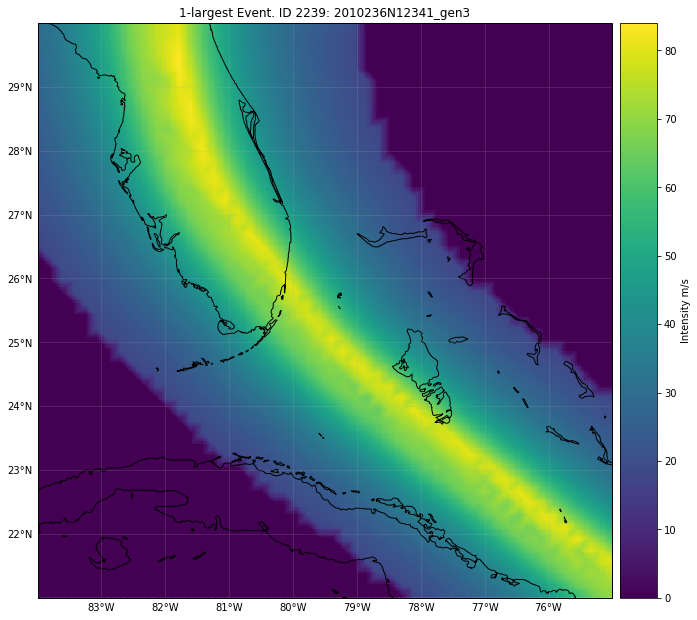

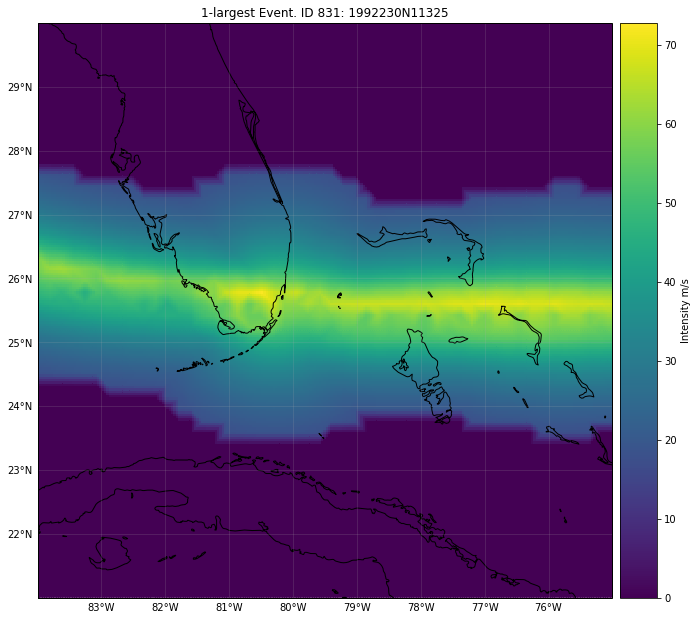

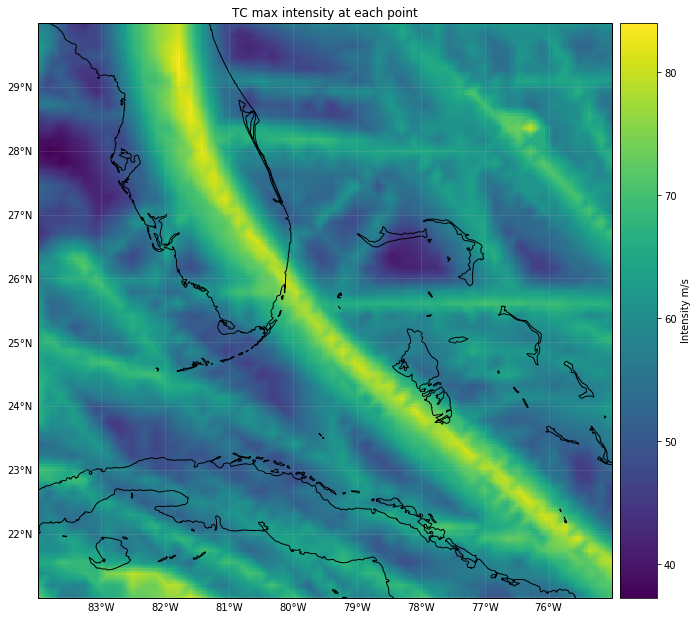

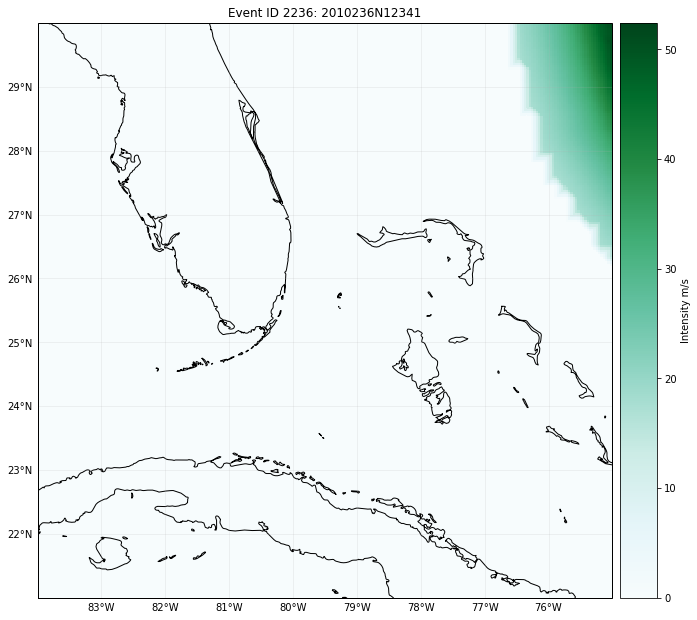

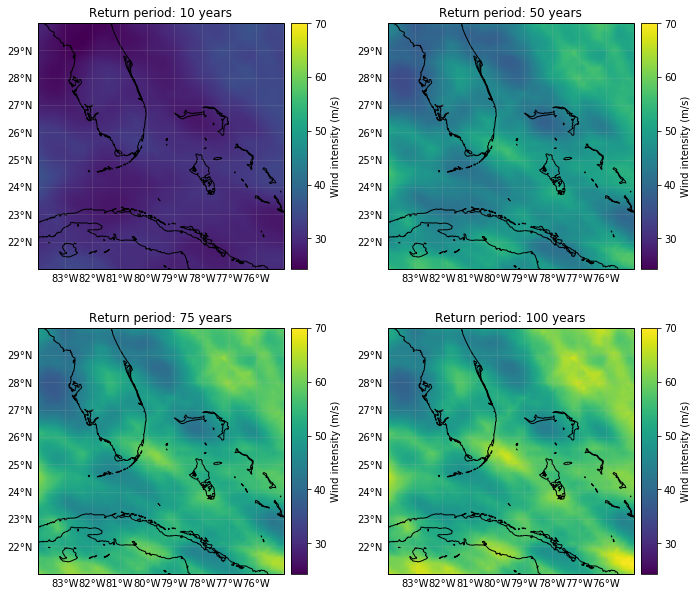

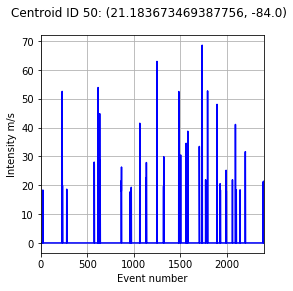

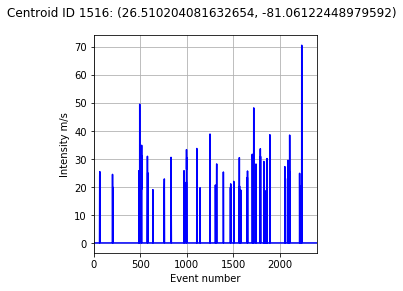

In [6]:
# 1. intensities of the largest event (defined as greater sum of intensities):
# all events:
haz_tc_fl.plot_intensity(event=-1) # 2010236N12341_gen3 is a synthetic event
# only historical events:
haz_tc_fl.select(orig=True).plot_intensity(-1) # largest historical event: 1992230N11325 hurricane ANDREW

# 2. maximum intensities at each centroid:
haz_tc_fl.plot_intensity(event=0)

# 3. intensities of hurricane ANDREW with event_name 1992230N11325:
haz_tc_fl.plot_intensity(event='2010236N12341', cmap='BuGn') # setting color map

# 4. tropical cyclone intensities maps for the return periods [10, 50, 75, 100]
_, _, res = haz_tc_fl.plot_rp_intensity([10, 50, 75, 100])

# 5. intensities of all the events in centroid with id 50
haz_tc_fl.plot_intensity(centr=50)

# 5. intensities of all the events in centroid closest to lat, lon = (26.5, -81)
haz_tc_fl.plot_intensity(centr=(26.5, -81));

## Write a hazard

Hazards can be written and read in hdf5 format as follows:

In [7]:
haz_tc_fl.write_hdf5('results/haz_tc_fl.h5')

haz = Hazard('TC')
haz.read_hdf5('results/haz_tc_fl.h5')
haz.check()

2019-03-04 09:46:04,810 - climada.util.checker - DEBUG - Centroids.region_id not set. 


Pickle will work as well:

In [8]:
from climada.util.save import save
# this generates a results folder in the current path and stores the output there
save('tutorial_haz_tc_fl.p', haz_tc_fl)

2019-03-04 09:46:04,824 - climada.util.save - INFO - Written file /Users/aznarsig/Documents/Python/climada_python/script/tutorial/results/tutorial_haz_tc_fl.p
